In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import configparser 
config = configparser.ConfigParser()
config.read('config.ini')
ip = config['DEFAULT']['IP']
port = config['DEFAULT']['MongoDB-Port']

from pymongo import MongoClient
client = MongoClient(ip, int(port))

In [27]:
col_names = ['fv', 'dv']

In [70]:
col = client['Twitter']['twitter-richard-2017']
col.find().count()

21797263

In [71]:
fv_tweets = list(col.find({'$text': {'$search': '"family violence"'}}, no_cursor_timeout=True))
len(fv_tweets)

3501

In [72]:
dv_tweets = list(col.find({'$text': {'$search': '"domestic violence"'}}, no_cursor_timeout=True))
len(dv_tweets)

3469

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

In [82]:
tweets = {}
tweets['fv'] = fv_tweets
tweets['dv'] = dv_tweets
print(len(tweets['fv']), len(tweets['dv']))

3501 3469


In [92]:
def get_freqs(col_name):
    freqs = {}
    for tweet in tweets[col_name]:
        try:
            for tag in tweet['doc']['entities']['hashtags']:
                text = tag['text'].strip().lower()
                if text not in ['dv','familyviolence','domesticviolence', 'auapol', 'family']:
                    freqs[text] = freqs.get(text, 0) + 1
        except:
            continue
    return freqs

In [93]:
tag_freqs = {}
for col_name in col_names:
    tag_freqs[col_name] = get_freqs(col_name)

In [94]:
with open('output/fv.csv', 'w') as f:
    for key in sorted(tag_freqs['fv'], key=tag_freqs['fv'].get, reverse=True):
        f.write(key+','+str(tag_freqs['fv'][key])+'\n')
        
with open('output/dv.csv', 'w') as f:
    for key in sorted(tag_freqs['dv'], key=tag_freqs['dv'].get, reverse=True):
        f.write(key+','+str(tag_freqs['dv'][key])+'\n')

In [78]:
def draw_pie_chart(col_name):
    freqs = tag_freqs[col_name]
    labels = []                       
    sizes = []                        
    n = 0                             
    for key in sorted(freqs, key=freqs.get, reverse=True):
        if key in ['dv','familyviolence','domesticviolence', 'auapol', 'family']:
            continue
        labels.append(key)
        sizes.append(freqs[key])
        n += 1
        if n == 10:                   
            break

    print('Pie Chart for '+(col_name.upper()))
    plt.figure(figsize=(8,8))
    explode = (0.1,0,0,0,0,0,0,0,0,0)                      
    plt.pie(sizes, labels=labels, startangle=140, explode=explode) 
    plt.axis('equal')
    plt.show()
    print()

Pie Chart for FV


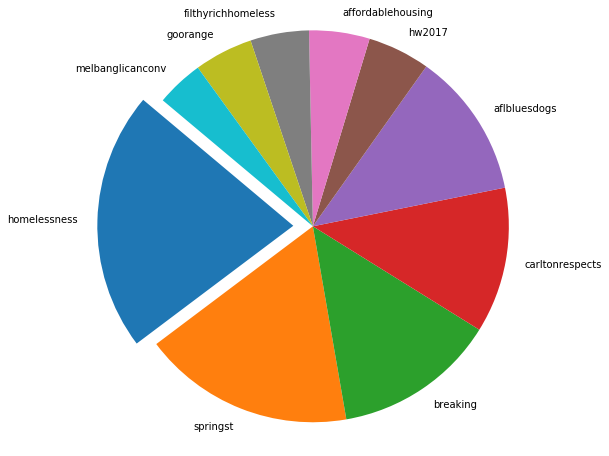

Pie Chart for DV


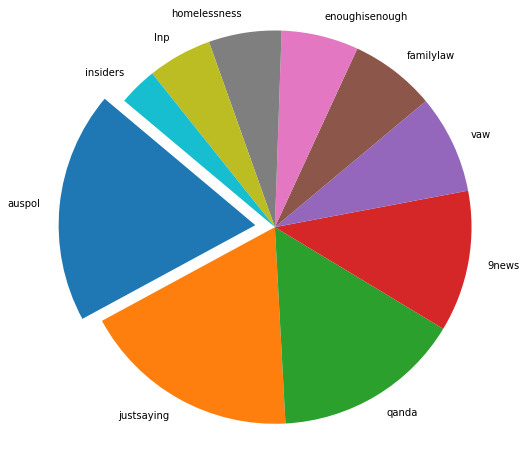

In [37]:
for col_name in col_names:
    draw_pie_chart(col_name)

# Exclude Retweets

In [95]:
# remove duplicates

tweets_no_rt = {}
for col_name in col_names:
    unique = set()
    tweets_no_rt[col_name] = []
    for tweet in tweets[col_name]:
        text = tweet['doc']['text'].strip()
        if text == '' or text.startswith("RT"):
            continue
        if text not in unique:
            unique.add(text)
            tweets_no_rt[col_name].append(tweet)
            
print(len(tweets_no_rt['fv']), len(tweets_no_rt['dv']))

976 1398


In [99]:
def get_freqs_no_rt(col_name):
    freqs = {}
    for tweet in tweets_no_rt[col_name]:
        try:
            for tag in tweet['doc']['entities']['hashtags']:
                text = tag['text'].strip().lower()
                if text not in ['dv','familyviolence','domesticviolence', 'auapol', 'family']:
                    freqs[text] = freqs.get(text, 0) + 1
        except:
            continue
    return freqs

In [100]:
tag_freqs = {}
for col_name in col_names:
    tag_freqs[col_name] = get_freqs_no_rt(col_name)

In [101]:
with open('output/fv-no-rt.csv', 'w') as f:
    for key in sorted(tag_freqs['fv'], key=tag_freqs['fv'].get, reverse=True):
        f.write(key+','+str(tag_freqs['fv'][key])+'\n')
        
with open('output/dv-no-rt.csv', 'w') as f:
    for key in sorted(tag_freqs['dv'], key=tag_freqs['dv'].get, reverse=True):
        f.write(key+','+str(tag_freqs['dv'][key])+'\n')

Pie Chart for FV


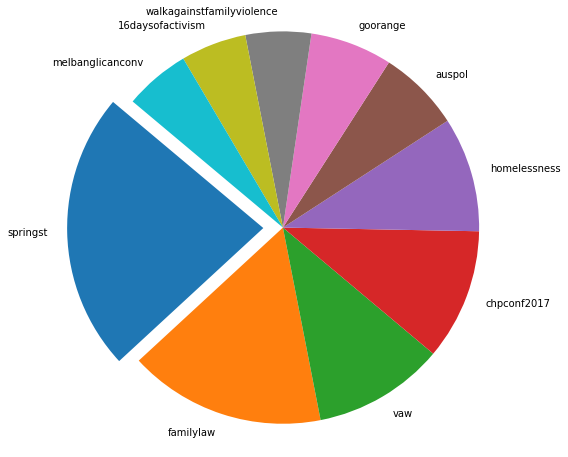


Pie Chart for DV


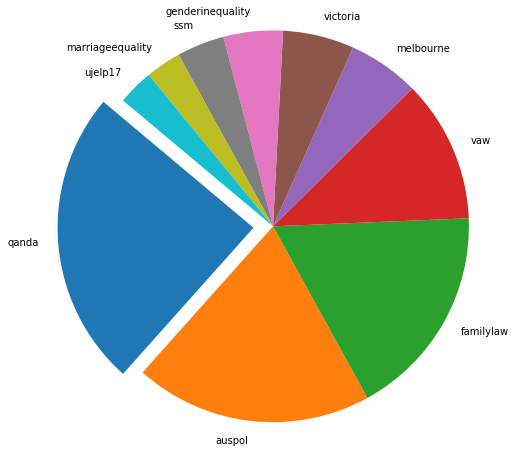

In [79]:
for col_name in col_names:
    draw_pie_chart(col_name)

# Examples for Each Hashtag

In [56]:
col_name = 'fv'
for freqs in [fv_freqs, dv_freqs]:
    if col_name == 'fv':
        tweets = fv_tweets
    else:
        tweets = dv_tweets
    col_name = 'dv'
    
    for key in sorted(freqs, key=freqs.get, reverse=True)[:10]:
        if key in ['dv','familyviolence','domesticviolence', 'auapol']:
            continue
            
        used = set()
        print('--------------------------------------------------------------------------------')        
        print('\n'+key+':\n')
        count = 0
        enough = False
        for tweet in tweets:
            if enough:
                break
            try:
                for tag in tweet['doc']['entities']['hashtags']:
                    if tag['text'].strip().lower() == key:
                        text = tweet['doc']['text']
                        if text not in used:
                            print(text)
#                             used.add(text)
                            count += 1
                            if count == 5:
                                enough = True
            except:
                continue
        print('--------------------------------------------------------------------------------')        

--------------------------------------------------------------------------------

homelessness:

"There are three main causes of #homelessness: #family violence, unemployment and #housingaffordability" #MelbAnglicanConv
Family violence, unemployment and housing affordability are the three leading causes of #homelessness #MelbAnglicanConv
In Australia, domestic and family violence is the leading cause of #homelessness in women #DomesticViolence #FamilyViolence
RT @CHPVic: "There are three main causes of #homelessness: #family violence, unemployment and #housingaffordability" #MelbAnglicanConv
RT @CHPVic: "There are three main causes of #homelessness: #family violence, unemployment and #housingaffordability" #MelbAnglicanConv
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

springst:

A very sad day at #springst with the loss of Fiona Richardson. A true fighter against Family

In [81]:
len(tag_freqs['dv'])

147